In [1]:
%matplotlib inline
import random
random.seed(0)
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

skips = 2
X_train=np.delete(X_train, list(range(0, X_train.shape[1], skips)), axis=1)
X_train=np.delete(X_train, list(range(0, X_train.shape[2], skips)), axis=2)
X_train = X_train.reshape(X_train.shape[0],-1)

X_test = np.delete(X_test, list(range(0, X_test.shape[1], skips)), axis=1)
X_test = np.delete(X_test, list(range(0, X_test.shape[2], skips)), axis=2)
X_test = X_test.reshape(X_test.shape[0],-1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Using TensorFlow backend.


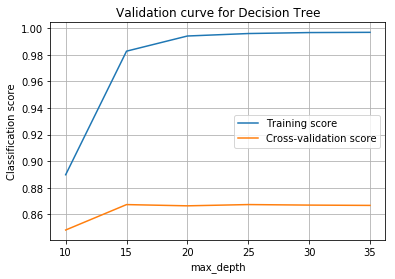

In [3]:
max_depth = 35
seed = 0
n_cv = 10 

dt = DecisionTreeClassifier(random_state=seed, min_impurity_decrease=0.00001)
depth_range = np.arange(10,max_depth+1,5)
train_scores, test_scores = validation_curve(dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=n_cv, n_jobs=-1)

plt.figure()
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for Decision Tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [5]:
tuned_params = {'max_depth' : depth_range}
clf = GridSearchCV(dt, param_grid=tuned_params, cv=5, n_jobs=-1)

clf.fit(X_train, y_train)
best_dt_params = clf.best_params_
print("Best parameters set for decision tree:")
print(best_dt_params)
dt_pred_best = clf.predict(X_test)
best_accuracy = accuracy_score(y_test, dt_pred_best)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy * 100))

Best parameters set for decision tree:
{'max_depth': 15}
Accuracy of decision tree is 88.20%


In [6]:
train_sizes=np.linspace(.3, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=n_cv, train_sizes=train_sizes, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

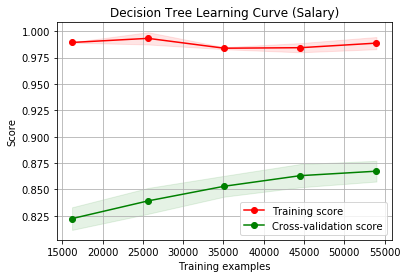

In [7]:
plt.figure()
plt.title("Decision Tree Learning Curve (Salary)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.show()

In [8]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       980
           1       0.94      0.97      0.95      1135
           2       0.87      0.85      0.86      1032
           3       0.86      0.85      0.86      1010
           4       0.88      0.88      0.88       982
           5       0.84      0.82      0.83       892
           6       0.91      0.90      0.90       958
           7       0.91      0.91      0.91      1028
           8       0.83      0.81      0.82       974
           9       0.84      0.87      0.86      1009

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [9]:
# https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(15,15)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)


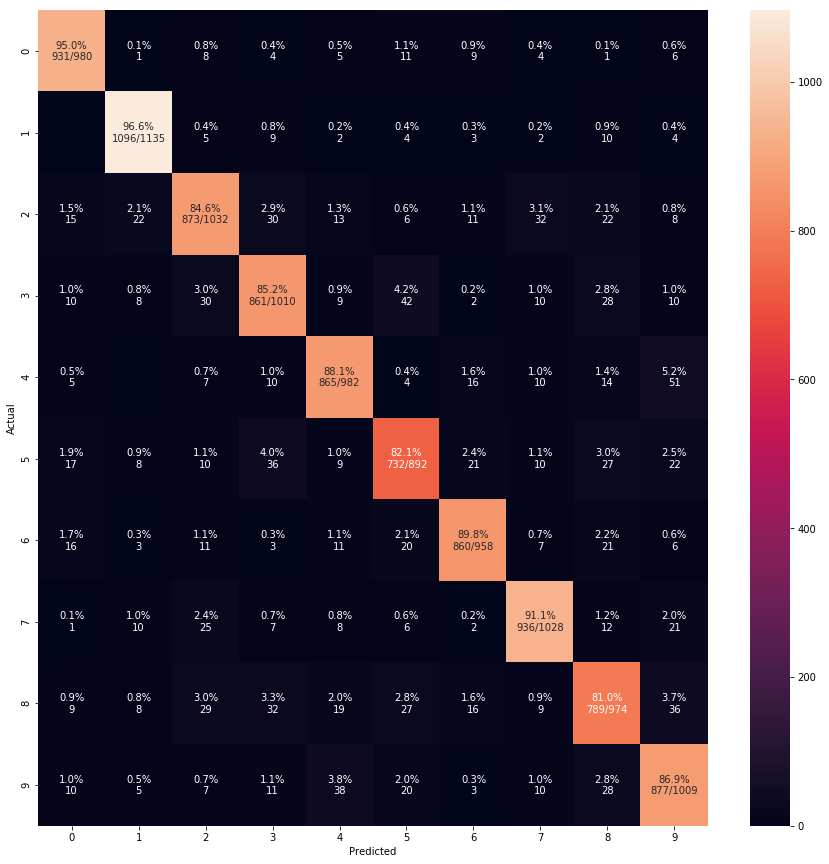

In [10]:
cm_analysis(y_test, clf.predict(X_test), range(10))

In [14]:
# Training time
import time

clf = DecisionTreeClassifier(random_state=seed, min_impurity_decrease=0.00001,max_depth=15)
start_time = time.time()
clf.fit(X_train, y_train)
print("Time taken for training %s seconds" % (time.time() - start_time))


start_time = time.time()
pred = clf.predict(X_test)
print("Time taken for inference %s seconds" % (time.time() - start_time))

Time taken for training 71.0059299469 seconds
Time taken for inference 0.0918591022491 seconds
